# 01 — EDA & Preprocessing


# Vehicle Recall Patterns in the United States: Clustering Recalls by Severity

In [ ]:
import gdown # need to run '!pip install gdown' to use this
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# ML and statistics
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

RANDOM_STATE = 42

In [ ]:
# this automatically downloads the dataset to our colab directory
# colab directories are cleared after we end a session
# so we neeed to download it every time
url = "https://drive.google.com/uc?id=1Me7DO_0WWt7NpyxIfo5anFAWJQflJHcA"
output = "recalls_data.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Me7DO_0WWt7NpyxIfo5anFAWJQflJHcA
To: /content/recalls_data.csv
100%|██████████| 23.2M/23.2M [00:00<00:00, 35.4MB/s]


'recalls_data.csv'

In [ ]:
# check to make sure data was imported correctly
recall_df_full = pd.read_csv("recalls_data.csv")
print(recall_df_full.shape)
display(recall_df_full.head())

(29367, 15)


,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action,Park Outside Advisory,Do Not Drive Advisory,Completion Rate % (Blank - Not Reported)
0,09/30/2025,25V653000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Thor Motor Coach,LP Tank May Detach and Become a Road Hazard,EQUIPMENT,RC000331,Vehicle,23,Thor Motor Coach (TMC) is recalling certain 20...,A detached tank can create a road hazard for o...,The remedy is currently under development. Own...,No,No,NaN
1,09/25/2025,25E061000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Cognito Motorsports,Ball Joint Disengaging from Upper Control Arm,SUSPENSION,NaN,Equipment,12160,Cognito Motorsports (Cognito) is recalling cer...,An upper control arm that disengages can cause...,Owners are advised not to drive their trucks u...,No,Yes,NaN
2,09/25/2025,25V649000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Kia America, Inc.",Fire from HVAC Wiring Harness,ELECTRICAL SYSTEM,SC351,Vehicle,39536,"Kia America, Inc. (Kia) is recalling certain 2...",A fire increases the risk of injury.,Dealers will replace the wiring harness and bl...,No,No,NaN
3,09/25/2025,25C010000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Evenflo Company, Inc.",Choking Hazard from Foam in Child Seat Headrest,CHILD SEAT,NaN,Child Seat,324997,"Evenflo Company, Inc. (Evenflo) is recalling c...",Pieces of foam can present a choking hazard to...,Evenflo will mail owners additional tape seal ...,No,No,NaN
4,09/25/2025,25V645000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Jaguar Land Rover North America, LLC",Rearview Camera Image May Not Display,BACK OVER PREVENTION,D053,Vehicle,3818,"Jaguar Land Rover North America, LLC (Land Rov...",A rearview camera image that does not display ...,"Dealers will replace the rearview camera, free...",No,No,NaN


In [ ]:
# in our assessment, we will only use vehicle data
unique_recall_type = recall_df_full['Recall Type'].value_counts()

print(unique_recall_type)

num_unique_from_counts = len(unique_recall_type)
print(f"Number of Unique Categories (from value_counts): {num_unique_from_counts}")

Recall Type
Vehicle       25564
Equipment      2782
Tire            775
Child Seat      246
Name: count, dtype: int64
Number of Unique Categories (from value_counts): 4


In [ ]:
# remove rows that are not 'vehicle' in Recall Type
recall_df = recall_df_full[recall_df_full['Recall Type'] == 'Vehicle']

print(recall_df.shape)

(25564, 15)


## Evaluate Missing Data

In [ ]:
#print number of missing entries in each column
print(f'Number of Values in Dataset: {recall_df.shape[0]}')
print("Missing Entries")
print(recall_df.isna().sum())

# interpretation
# text-based columns have some missing data that needs to be managed
  # Component - 25% missing
  # Recall Description - 8.2%
  # Consequence Summary - 16.6%
  # Corrective Action - 8.1%
# completion rate has high missingness (63.6%), making it unusable for our analysis

Number of Values in Dataset: 25564
Missing Entries
Report Received Date                            0
NHTSA ID                                        0
Recall Link                                     0
Manufacturer                                    0
Subject                                         0
Component                                    6188
Mfr Campaign Number                            97
Recall Type                                     0
Potentially Affected                            0
Recall Description                           2178
Consequence Summary                          4121
Corrective Action                            2165
Park Outside Advisory                           0
Do Not Drive Advisory                           0
Completion Rate % (Blank - Not Reported)    15897
dtype: int64


In [ ]:
#test whether missing values in consequence summary are independent of manufacturer using chi^2 test of independence
recall_df["missingConsequence"] = recall_df["Consequence Summary"].isna().astype(int)
missingTable = pd.crosstab(recall_df["Manufacturer"], recall_df["missingConsequence"])
chi2, p, dof, expected = chi2_contingency(missingTable)

#output results - missing values in consequence summary are not independent of manufacturer
print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p:.3e}")

# intrepretation of chi square result
# missing Consequences Summary values depend on manufacturer
# missingness is not random

Chi-square statistic = 9863.156
Degrees of freedom = 1839
p-value = 0.000e+00


/tmp/ipython-input-2576525128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall_df["missingConsequence"] = recall_df["Consequence Summary"].isna().astype(int)


##Data Cleaning
Extract dates, manage missing data

In [ ]:
#drop any rows missing manufacturer and/or recall date from df
recall_df = recall_df.dropna(subset=['Manufacturer', 'Report Received Date'])

In [ ]:
# split extraction date into month, day, and year from recall_date col
# allow for assessment of yearly and monthly trends

recall_df['Report Received Date'] = pd.to_datetime(recall_df['Report Received Date'], errors='coerce')
recall_df = recall_df.dropna(subset=['Report Received Date']) # drop rows where date conversion failed

# extract date components
recall_df['Year'] = recall_df['Report Received Date'].dt.year
recall_df['Month'] = recall_df['Report Received Date'].dt.month
recall_df['Day'] = recall_df['Report Received Date'].dt.day

# add cols for month name and day of week to aid in exploratory analysis
recall_df['Month Name'] = recall_df['Report Received Date'].dt.month_name()
recall_df['Day of Week'] = recall_df['Report Received Date'].dt.day_name()

In [ ]:
# handle remaining missing vals and check again for missingness

# drop Completion Rate col - this col will be ignored in analysis due to high missingness
recall_df.drop(columns=['Completion Rate % (Blank - Not Reported)'], inplace=True)

#fill in any blank consequence summaries and component
recall_df['Consequence Summary'] = recall_df['Consequence Summary'].fillna("No description")
recall_df['Component'] = recall_df['Component'].fillna("Unknown")

recall_df.isna().sum()

,0
Report Received Date,0
NHTSA ID,0
Recall Link,0
Manufacturer,0
Subject,0
Component,0
Mfr Campaign Number,97
Recall Type,0
Potentially Affected,0
Recall Description,2178


In [ ]:
# make df with only feature cols
#print(recall_df.columns.tolist())

feature_cols= ['Year', 'Month Name', 'Day of Week',
               'Manufacturer', 'Component', 'Recall Type',
               'Do Not Drive Advisory','Potentially Affected', 'Consequence Summary'
               ]
recall_df = recall_df[feature_cols]
display(recall_df)

,Year,Month Name,Day of Week,Manufacturer,Component,Recall Type,Do Not Drive Advisory,Potentially Affected,Consequence Summary
0,2025,September,Tuesday,Thor Motor Coach,EQUIPMENT,Vehicle,No,23,A detached tank can create a road hazard for o...
2,2025,September,Thursday,"Kia America, Inc.",ELECTRICAL SYSTEM,Vehicle,No,39536,A fire increases the risk of injury.
4,2025,September,Thursday,"Jaguar Land Rover North America, LLC",BACK OVER PREVENTION,Vehicle,No,3818,A rearview camera image that does not display ...
5,2025,September,Thursday,"BMW of North America, LLC",ELECTRICAL SYSTEM,Vehicle,No,145102,An overheated starter motor can ignite nearby ...
6,2025,September,Thursday,"BMW of North America, LLC",ELECTRICAL SYSTEM,Vehicle,No,4,An engine stall increases the risk of a crash ...
...,...,...,...,...,...,...,...,...,...
29362,1966,September,Thursday,Honda (American Honda Motor Co.),POWER TRAIN,Vehicle,No,18572,No description
29363,1966,September,Monday,"RENAULT, INCORPORATED","SERVICE BRAKES, HYDRAULIC",Vehicle,No,125,IF SUCH LEAKAGE OCCURS AND IF ENOUGH BRAKE FLU...
29364,1966,January,Wednesday,"General Motors, LLC",STEERING,Vehicle,No,138878,No description
29365,1966,January,Wednesday,"General Motors, LLC",STEERING,Vehicle,No,70644,No description


##Exploratory Data Analysis and Visualization
Assess trends, patterns, distribution

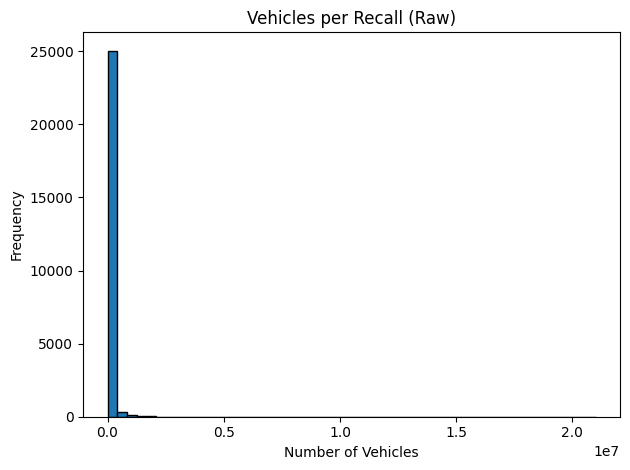

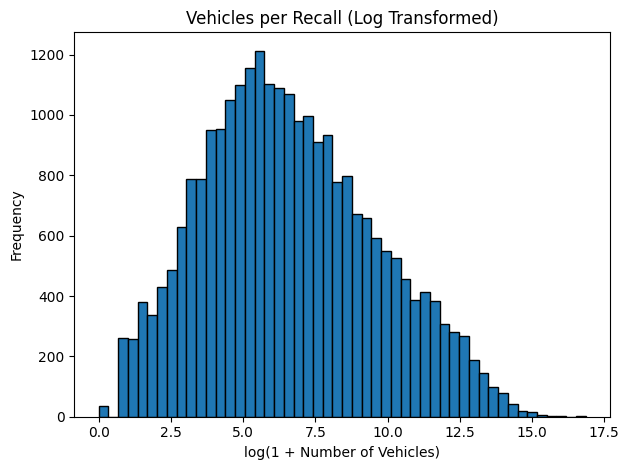

In [ ]:
#Plot distribution of number of vehicles affected per recall
recall_df["Potentially Affected"].plot(kind="hist", bins = 50, edgecolor='black')
plt.title("Vehicles per Recall (Raw)")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Number vehicles per recall is right skewed, so log transform to normalize
np.log1p(recall_df["Potentially Affected"]).plot(kind="hist", bins = 50, edgecolor='black')
plt.title("Vehicles per Recall (Log Transformed)")
plt.xlabel("log(1 + Number of Vehicles)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Save log transformation in dataset
recall_df["Potentially_Affected_LogTransform"] = np.log1p(recall_df["Potentially Affected"])



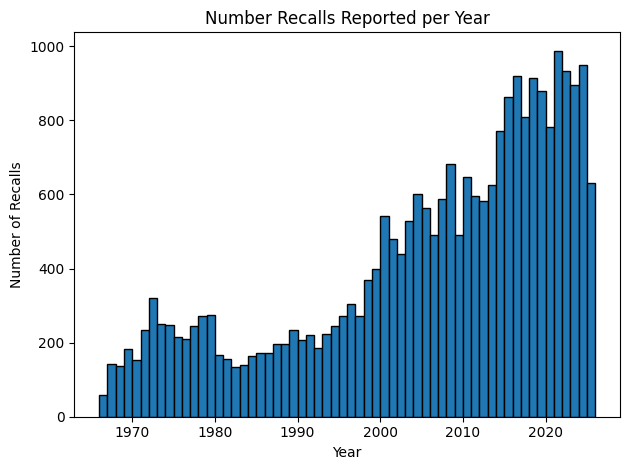

Summary of Recalls per Year:
 Average Recalls    426.066667
Median Recalls     289.000000
Min Recalls         58.000000
Max Recalls        988.000000
dtype: float64


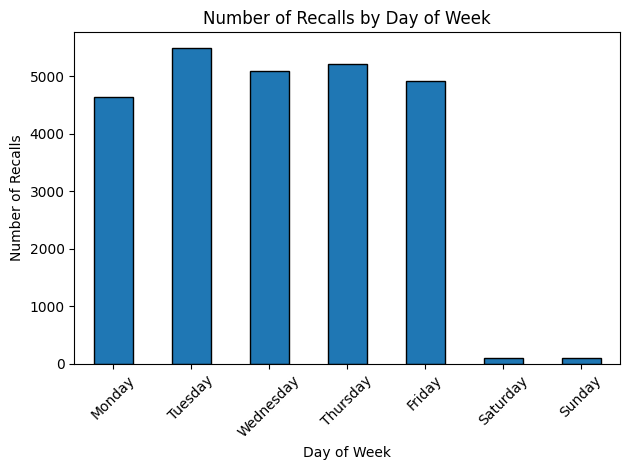

Summary of Recalls per Week Day:
 Average Recalls    3652.0
Median Recalls     4916.0
Min Recalls         105.0
Max Recalls        5488.0
dtype: float64


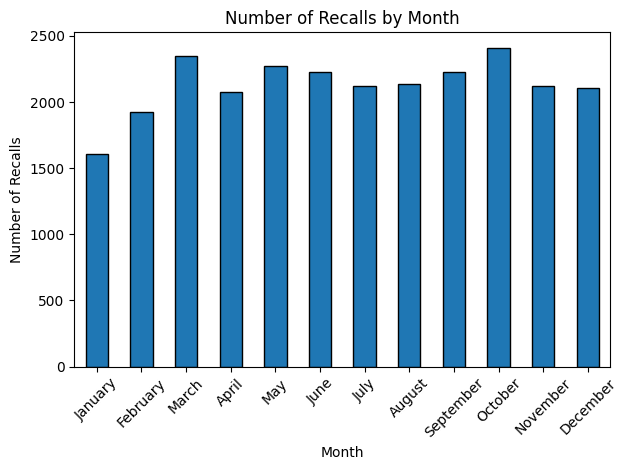

Summary of Recalls per Month:
 Average Recalls    2130.333333
Median Recalls     2127.000000
Min Recalls        1607.000000
Max Recalls        2407.000000
dtype: float64


In [ ]:
# date / time trends for number of recalls

#Plot number of recalls per year for entire dataset
# recalls increasing over the years - why?
# note that 2025 is low bc we do not have complete data
plt.hist(recall_df['Year'], bins=range(1966, 2027), edgecolor='black')
plt.title("Number Recalls Reported per Year")
plt.xlabel("Year")
plt.ylabel("Number of Recalls")
plt.tight_layout()
plt.show()

#Summary table: recalls per year
recalls_per_year_counts = recall_df.groupby('Year').size()
year_summary = recalls_per_year_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Year:\n", year_summary)

# histogram for day of week recalls
# no significant patterns found
# it is expected that recalls are announced M-F because of work week
# are recalls made on Sat / Sun very severe?
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

recall_df['Day of Week'].value_counts().reindex(day_order).plot(
    kind='bar', edgecolor='black')
plt.title("Number of Recalls by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Recalls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Summary table: recalls per day
recalls_per_day_counts = recall_df.groupby('Day of Week').size().reindex(day_order)
day_summary = recalls_per_day_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Week Day:\n", day_summary)


# histogram for monthly recalls
# jan and feb have lowest num of recalls announced
# march and october have the highest
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

recall_df['Month Name'].value_counts().reindex(month_order).plot(
    kind='bar', edgecolor='black')
plt.title("Number of Recalls by Month")
plt.xlabel("Month")
plt.ylabel("Number of Recalls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Summary table: recalls per Month
recalls_per_month_counts = recall_df.groupby('Month Name').size().reindex(month_order)
month_summary = recalls_per_month_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Month:\n", month_summary)

                                Manufacturer  Number of Recalls
0                        General Motors, LLC               1675
1                         Ford Motor Company               1611
2                     Chrysler (FCA US, LLC)               1407
3                         Forest River, Inc.                604
4          Volkswagen Group of America, Inc.                577
5                  BMW of North America, LLC                559
6          Daimler Trucks North America, LLC                523
7                     Mercedes-Benz USA, LLC                486
8           Honda (American Honda Motor Co.)                444
9                 Nissan North America, Inc.                427
10                         Mack Trucks, Inc.                416
11                       PACCAR Incorporated                410
12                    Blue Bird Body Company                397
13                 International Motors, LLC                387
14                          FREIGHTLINER

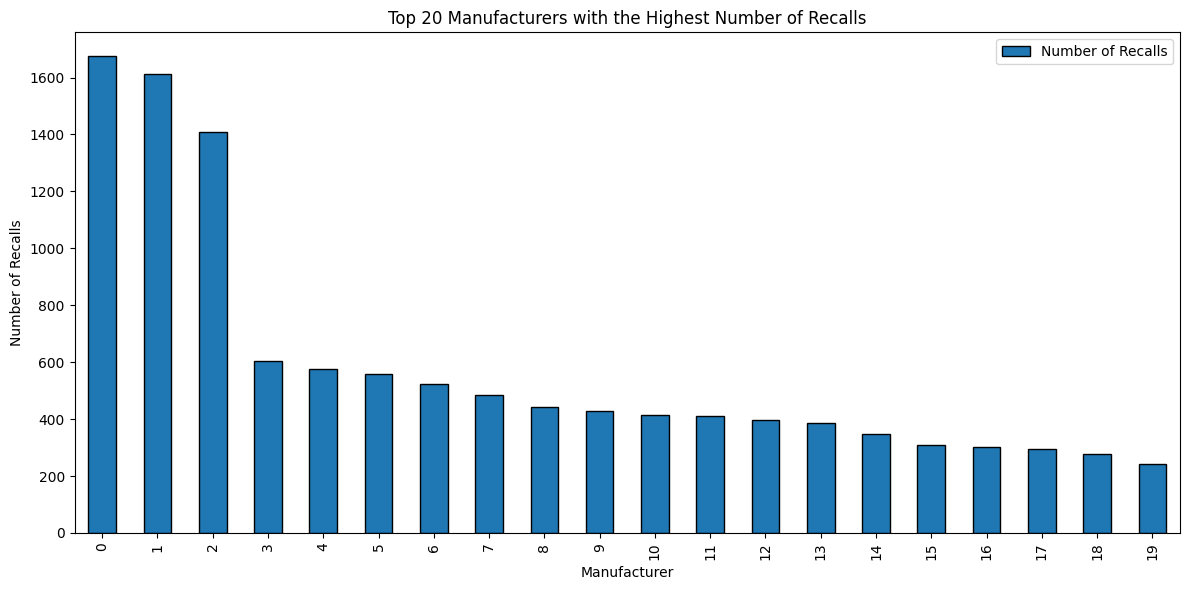

In [ ]:
#Number of Recalls per Manufacturer
recalls_per_manufacturer = recall_df.groupby('Manufacturer').size().sort_values(ascending=False).reset_index(name='Number of Recalls')
print(recalls_per_manufacturer.head(20))

#plot recalls per manufacturer
top_n = 20
recalls_per_manufacturer.head(top_n).plot(kind='bar', edgecolor='black', figsize=(12,6))
plt.title('Top 20 Manufacturers with the Highest Number of Recalls')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Recalls')
plt.tight_layout()
plt.show()

                                                   mean    median    min  \
Manufacturer                                                               
Harbor Freight Tools                      234778.000000  234778.0  95237   
Toyota Motor Engineering & Manufacturing  226760.838710   37684.0      2   
Honda (American Honda Motor Co.)          178050.245495   11556.5      0   
Tesla, Inc.                               156266.904762    7444.5      1   
Ford Motor Company                        136556.285537    9400.0      1   
General Motors, LLC                       122153.197612    6083.0      0   
Chrysler (FCA US, LLC)                    102248.867804    7400.0      1   
Nissan North America, Inc.                102169.096019   15223.0      2   
Hyundai Motor America                      98185.884058   17803.5      2   
Subaru of America, Inc.                    87364.284884   26371.0      5   
Kia America, Inc.                          83494.409091   26416.0      1   
Toyota Motor

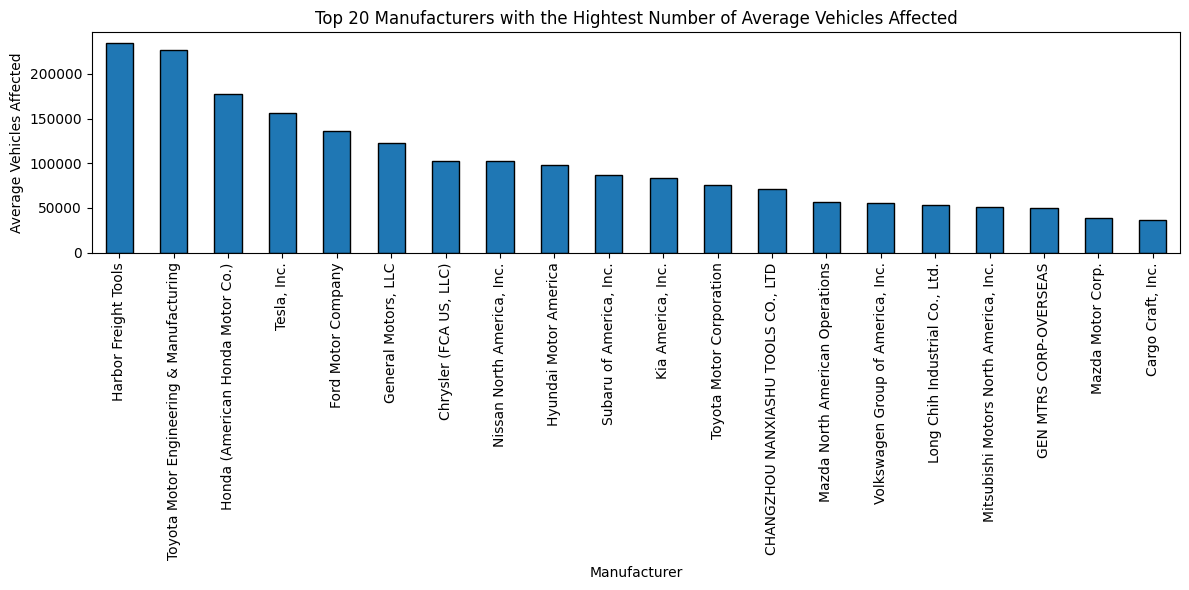

In [ ]:
#Vehicles Affected per Manufacturer
vehicles_per_manufacturer = recall_df.groupby('Manufacturer')['Potentially Affected'].agg(['mean','median','min','max']).sort_values('mean', ascending=False)
print(vehicles_per_manufacturer.head(20))

#plot of average vehicles affected for the top 20 manufacturers
vehicles_per_manufacturer['mean'].head(top_n).plot(kind='bar', edgecolor='black', figsize=(12,6))
plt.title('Top 20 Manufacturers with the Hightest Number of Average Vehicles Affected')
plt.xlabel('Manufacturer')
plt.ylabel('Average Vehicles Affected')
plt.tight_layout()
plt.show()


## Export prepared dataset
This file is used by `02_clustering.ipynb`.


In [17]:
from pathlib import Path

Path("data/processed").mkdir(parents=True, exist_ok=True)

# 'recall_df' is the cleaned vehicle-only dataframe produced above.
out_path = Path("data/processed/recalls_prepared.csv")
recall_df.to_csv(out_path, index=False)
print("Saved:", out_path.resolve(), "| rows:", len(recall_df))


Saved: /content/data/processed/recalls_prepared.csv | rows: 25564
